In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

diseases = ['Infertility_female', 'Infertility_male', 'Testiuclar', 'Ovarian', 'Uterine', 'Prostatic']

# Collect data for all diseases
receptor_data = {}
dfs = []
for disease in diseases:
    df = pd.read_excel(f'Disease_predict/{disease}.xlsx')
    dfs.append(df)
    receptor_names = [col for col in df.columns if col != 'cas']  # 81 receptors
    receptor_data[disease] = df

# Merge all disease data
all_df = pd.concat(dfs, ignore_index=True)

# Remove duplicates by CAS (keep the first occurrence; can be changed to e.g. max value)
all_df = all_df.drop_duplicates(subset="cas", keep="first").set_index("cas")

scaler = StandardScaler()
all_scaled = pd.DataFrame(
    scaler.fit_transform(all_df),
    index=all_df.index,
    columns=all_df.columns
)

receptor_data_scaled = {}

for disease in diseases:
    df = pd.read_excel(f'Disease_predict/{disease}.xlsx')  # directory name kept as-is
    cas_list = df['cas'].tolist()
    receptor_data_scaled[disease] = all_scaled.loc[all_scaled.index.intersection(cas_list)]


### 1 Common mechanisms

In [3]:
data = receptor_data_scaled
# data = receptor_data

In [4]:
# Calculate receptor activation intensity for each disease
disease_receptor_profiles = {}
receptor_summary_stats = []
all_top10 = []

for disease in diseases:
    df = data[disease]
    receptor_values = df[receptor_names].values
    
    # Compute receptor activation metrics
    mean_activation = np.mean(receptor_values, axis=0)  # Mean activation per receptor
    std_activation = np.std(receptor_values, axis=0)    # Activation variability per receptor
    max_activation = np.max(receptor_values, axis=0)    # Maximum activation per receptor
    
    # Compute total activation intensity per compound (sum across 81 receptors)
    total_activation_per_chemical = np.sum(receptor_values, axis=1)
    
    disease_receptor_profiles[disease] = {
        'receptor_means': mean_activation,
        'receptor_stds': std_activation,
        'receptor_maxs': max_activation,
        'total_activations': total_activation_per_chemical,
        'receptor_data': receptor_values
    }
    
    print(f"\n{disease}:")
    print(f"  Number of compounds: {len(df)}")
    print(f"  Total activation statistics (sum across 81 receptors):")
    print(f"    Mean total activation: {np.mean(total_activation_per_chemical):.2f}")
    print(f"    Activation range: {np.min(total_activation_per_chemical):.2f} - {np.max(total_activation_per_chemical):.2f}")
    print(f"    Standard deviation: {np.std(total_activation_per_chemical):.2f}")
    
    # Identify the Top 5 most strongly activated receptors for this disease
    top_receptors_idx = np.argsort(mean_activation)[-5:][::-1]
    print(f"  Top 5 most activated receptors:")
    for i, idx in enumerate(top_receptors_idx):
        print(f"    {i+1}. {receptor_names[idx]}: {mean_activation[idx]:.3f}")
    
    top_df = pd.DataFrame({
        "Disease": [disease] * 5,
        "Rank": range(1, 6),
        "Receptor": [receptor_names[idx] for idx in top_receptors_idx],
        "MeanActivation": [mean_activation[idx] for idx in top_receptors_idx]
    })
    all_top10.append(top_df)
    
    receptor_summary_stats.append({
        'Disease': disease,
        'Mean_Total_Activation': np.mean(total_activation_per_chemical),
        'Std_Total_Activation': np.std(total_activation_per_chemical),
        'Max_Total_Activation': np.max(total_activation_per_chemical),
        'Min_Total_Activation': np.min(total_activation_per_chemical)
    })

# Create summary DataFrame
summary_df = pd.DataFrame(receptor_summary_stats)

# Combine Top 5 receptors across all six diseases
all_top5_df = pd.concat(all_top10, ignore_index=True)
all_top5_df.to_csv('top5_common_receptors.csv', index=False)



Infertility_female:
  Number of compounds: 67
  Total activation statistics (sum across 81 receptors):
    Mean total activation: -7.79
    Activation range: -94.42 - 192.24
    Standard deviation: 58.32
  Top 5 most activated receptors:
    1. CYP1B1: 0.262
    2. SLC6A3: 0.203
    3. CFTR: 0.197
    4. AKR1C3: 0.195
    5. PTGS2: 0.182

Infertility_male:
  Number of compounds: 100
  Total activation statistics (sum across 81 receptors):
    Mean total activation: 2.33
    Activation range: -93.87 - 194.94
    Standard deviation: 65.58
  Top 5 most activated receptors:
    1. CYP1B1: 0.245
    2. KCNH2: 0.214
    3. CFTR: 0.192
    4. SLC6A3: 0.187
    5. AKR1C3: 0.173

Testiuclar:
  Number of compounds: 251
  Total activation statistics (sum across 81 receptors):
    Mean total activation: -8.58
    Activation range: -95.53 - 192.24
    Standard deviation: 60.92
  Top 5 most activated receptors:
    1. CYP1B1: 0.013
    2. CYP19A1: 0.008
    3. CFTR: 0.007
    4. AKR1C3: 0.004
    5

In [ ]:

counts = (all_top5_df.groupby("Receptor")
          .size()
          .reset_index(name="Count")
          .sort_values("Count", ascending=False))

common_receptors = counts[counts["Count"] >= 2]
len(common_receptors)

9

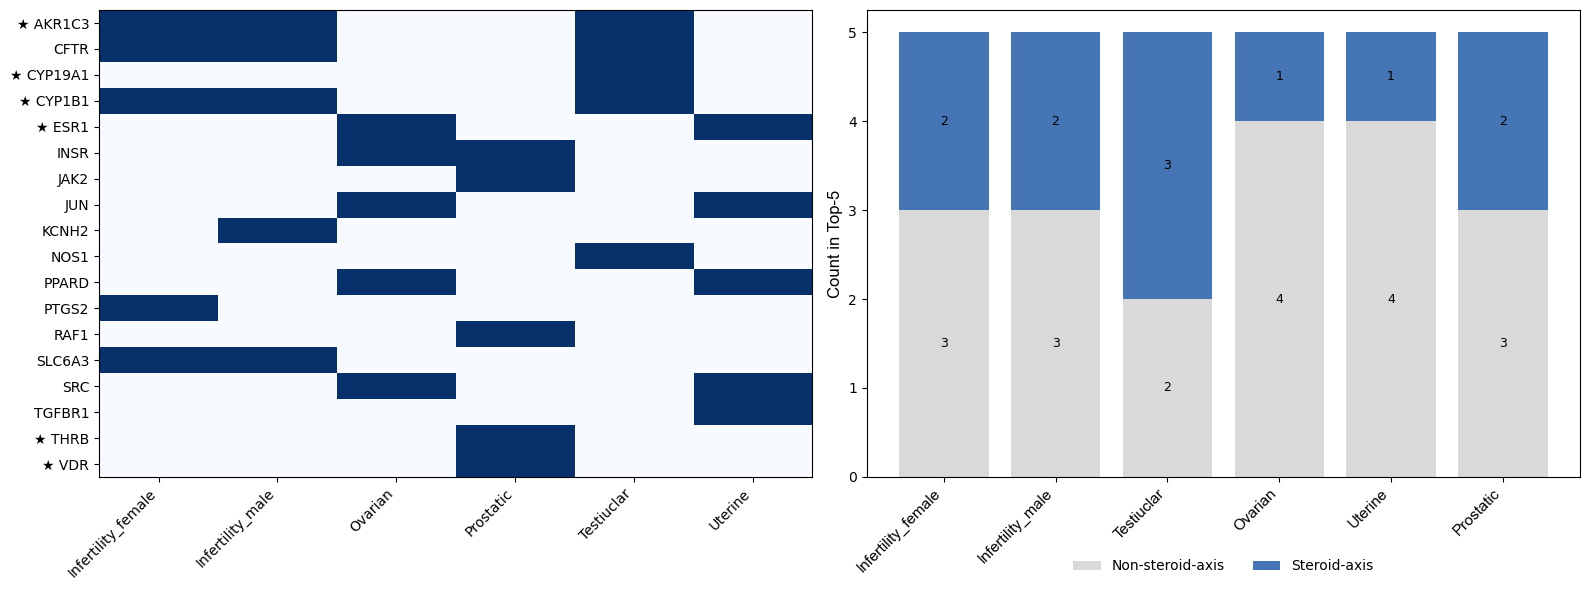

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import hypergeom

# Font settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# ========= 1. Prepare data =========
# all_top5_df columns: ["Disease", "Rank", "Receptor", "MeanActivation"]

# Ensure each Disease–Receptor pair is unique
all_top10_unique = all_top5_df.drop_duplicates(subset=["Disease", "Receptor"]).copy()
diseases = all_top10_unique["Disease"].unique().tolist()

# Define the set of steroid-axis receptors
steroid_axis = {"AR", "ESR1", "ESR2", "PGR", "NR3C1", "CYP19A1", "AKR1C3", "CYP1B1", "VDR", "THRB"}

# ========= 2. Construct the presence matrix (Receptor × Disease, 0/1) =========
presence = (
    all_top10_unique.assign(v=2)
    .pivot_table(index="Receptor", columns="Disease", values="v", aggfunc="max", fill_value=0)
)
presence["Count"] = presence.sum(axis=1)

# Keep only receptors appearing in at least two diseases
common_mat = presence.query("Count >= 2").drop(columns=["Count"])

# ========= 3. Plot figures =========
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Figure A: Common receptor occurrence matrix ---
ax = axes[0]
im = ax.imshow(common_mat.values, aspect='auto', cmap="Blues")
ax.set_xticks(range(len(common_mat.columns)))
ax.set_xticklabels(common_mat.columns, rotation=45, ha="right")
row_labels = [("★ " + r if r in steroid_axis else r) for r in common_mat.index]
ax.set_yticks(range(len(common_mat.index)))
ax.set_yticklabels(row_labels)
# ax.set_title("A. Common receptors across diseases\n(★ = Steroid-axis member)")
# fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# --- Figure B: Number of steroid-axis receptors in each disease’s Top-5 ---
ax = axes[1]
steroid_counts = []
non_counts = []

for d in diseases:
    recs = all_top10_unique.loc[all_top10_unique["Disease"] == d, "Receptor"].tolist()
    steroid_counts.append(sum([r in steroid_axis for r in recs]))
    non_counts.append(len(recs) - steroid_counts[-1])

x = np.arange(len(diseases))
bar1 = ax.bar(x, non_counts, label="Non-steroid-axis", color="#d9d9d9")
bar2 = ax.bar(x, steroid_counts, bottom=non_counts, label="Steroid-axis", color="#4575b4")

# Add value labels
for rects in [bar1, bar2]:
    for rect in rects:
        height = rect.get_height()
        if height > 0:
            ax.text(rect.get_x() + rect.get_width() / 2., rect.get_y() + height / 2.,
                    f'{int(height)}', ha='center', va='center', fontsize=9, color="black")

# Axis and title formatting
ax.set_xticks(x)
ax.set_xticklabels(diseases, rotation=45, ha="right", fontsize=11, fontname="Arial")
ax.set_ylabel("Count in Top-5", fontsize=12, fontname="Arial")
# ax.set_title("B. Steroid-axis coverage per disease", fontsize=14, weight="bold", fontname="Arial")

# Remove top and right borders
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.yaxis.grid(False)

# Legend formatting
ax.legend(ncol=2, loc="upper center", bbox_to_anchor=(0.5, -0.15), frameon=False, fontsize=10)

plt.savefig('common_receptor_analysis.svg', dpi=300)
plt.tight_layout()
plt.show()


### 2 Disease-specific targets

In [7]:
data = receptor_data
disease_receptor_profiles = {}
receptor_summary_stats = []
all_top10 = []

for disease in diseases:
    df = data[disease]
    receptor_values = df[receptor_names].values
    
    # Calculate receptor activation metrics
    mean_activation = np.mean(receptor_values, axis=0)  # Mean activation for each receptor
    std_activation = np.std(receptor_values, axis=0)    # Activation variability for each receptor
    max_activation = np.max(receptor_values, axis=0)    # Maximum activation for each receptor
    
    # Compute total activation strength (sum of scores across all 81 receptors)
    total_activation_per_chemical = np.sum(receptor_values, axis=1)  # Total activation per compound
    
    disease_receptor_profiles[disease] = {
        'receptor_means': mean_activation,
        'receptor_stds': std_activation,
        'receptor_maxs': max_activation,
        'total_activations': total_activation_per_chemical,
        'receptor_data': receptor_values
    }

# Analyze which receptors are most important for each specific disease
receptor_disease_matrix = np.zeros((len(receptor_names), len(diseases)))

for i, disease in enumerate(diseases):
    receptor_disease_matrix[:, i] = disease_receptor_profiles[disease]['receptor_means']

# Create the receptor–disease activation matrix DataFrame
receptor_df = pd.DataFrame(
    receptor_disease_matrix.T,
    columns=receptor_names,
    index=diseases
)

print("\nReceptor activation matrix (example: first 10 receptors):")
print(receptor_df.iloc[:, :10].round(3).to_string())

# Identify disease-specific receptors
print("\nDisease-specific receptors (more strongly activated compared to other diseases):")
for i, disease in enumerate(diseases):
    disease_activations = receptor_disease_matrix[:, i]
    other_activations = np.mean(
        receptor_disease_matrix[:, [j for j in range(len(diseases)) if j != i]],
        axis=1
    )
    
    # Compute activation advantage relative to other diseases
    activation_advantage = disease_activations - other_activations
    
    # Find receptors with the greatest activation advantage
    top_specific_idx = np.argsort(activation_advantage)[-5:][::-1]
    
    print(f"\nDisease-specific receptors for {disease}:")
    for j, idx in enumerate(top_specific_idx):
        advantage = activation_advantage[idx]
        print(f"  {j+1}. {receptor_names[idx]}: +{advantage:.3f} (Activation: {disease_activations[idx]:.3f})")
data = receptor_data
disease_receptor_profiles = {}
receptor_summary_stats = []
all_top10 = []

for disease in diseases:
    df = data[disease]
    receptor_values = df[receptor_names].values
    
    # Calculate receptor activation metrics
    mean_activation = np.mean(receptor_values, axis=0)  # Mean activation for each receptor
    std_activation = np.std(receptor_values, axis=0)    # Activation variability for each receptor
    max_activation = np.max(receptor_values, axis=0)    # Maximum activation for each receptor
    
    # Compute total activation strength (sum of scores across all 81 receptors)
    total_activation_per_chemical = np.sum(receptor_values, axis=1)  # Total activation per compound
    
    disease_receptor_profiles[disease] = {
        'receptor_means': mean_activation,
        'receptor_stds': std_activation,
        'receptor_maxs': max_activation,
        'total_activations': total_activation_per_chemical,
        'receptor_data': receptor_values
    }

# Analyze which receptors are most important for each specific disease
receptor_disease_matrix = np.zeros((len(receptor_names), len(diseases)))

for i, disease in enumerate(diseases):
    receptor_disease_matrix[:, i] = disease_receptor_profiles[disease]['receptor_means']

# Create the receptor–disease activation matrix DataFrame
receptor_df = pd.DataFrame(
    receptor_disease_matrix.T,
    columns=receptor_names,
    index=diseases
)

print("\nReceptor activation matrix (example: first 10 receptors):")
print(receptor_df.iloc[:, :10].round(3).to_string())

# Identify disease-specific receptors
print("\nDisease-specific receptors (more strongly activated compared to other diseases):")
for i, disease in enumerate(diseases):
    disease_activations = receptor_disease_matrix[:, i]
    other_activations = np.mean(
        receptor_disease_matrix[:, [j for j in range(len(diseases)) if j != i]],
        axis=1
    )
    
    # Compute activation advantage relative to other diseases
    activation_advantage = disease_activations - other_activations
    
    # Find receptors with the greatest activation advantage
    top_specific_idx = np.argsort(activation_advantage)[-5:][::-1]
    
    print(f"\nDisease-specific receptors for {disease}:")
    for j, idx in enumerate(top_specific_idx):
        advantage = activation_advantage[idx]
        print(f"  {j+1}. {receptor_names[idx]}: +{advantage:.3f} (Activation: {disease_activations[idx]:.3f})")



Receptor activation matrix (example: first 10 receptors):
                     ACHE  ACVR1  ADRA1A  ADRA2A  ADRA2B  ADRA2C  ADRB1  ADRB2  AGTR1  AGTR2
Infertility_female  5.491  6.168   5.518   5.550   5.651   5.472  5.310  5.570  5.035  5.529
Infertility_male    5.526  6.210   5.638   5.710   5.777   5.635  5.474  5.687  5.123  5.633
Testiuclar          5.395  6.118   5.594   5.638   5.716   5.537  5.414  5.635  5.091  5.566
Ovarian             5.391  6.195   5.629   5.691   5.744   5.575  5.487  5.689  5.162  5.624
Uterine             5.388  6.170   5.551   5.672   5.719   5.541  5.420  5.616  5.090  5.577
Prostatic           5.379  6.288   5.733   5.720   5.778   5.638  5.567  5.796  5.229  5.686

Disease-specific receptors (more strongly activated compared to other diseases):

Disease-specific receptors for Infertility_female:
  1. CYP1B1: +0.182 (Activation: 6.346)
  2. PTGS2: +0.119 (Activation: 5.736)
  3. SLC6A3: +0.119 (Activation: 5.891)
  4. AKR1C3: +0.115 (Activation: 5.98

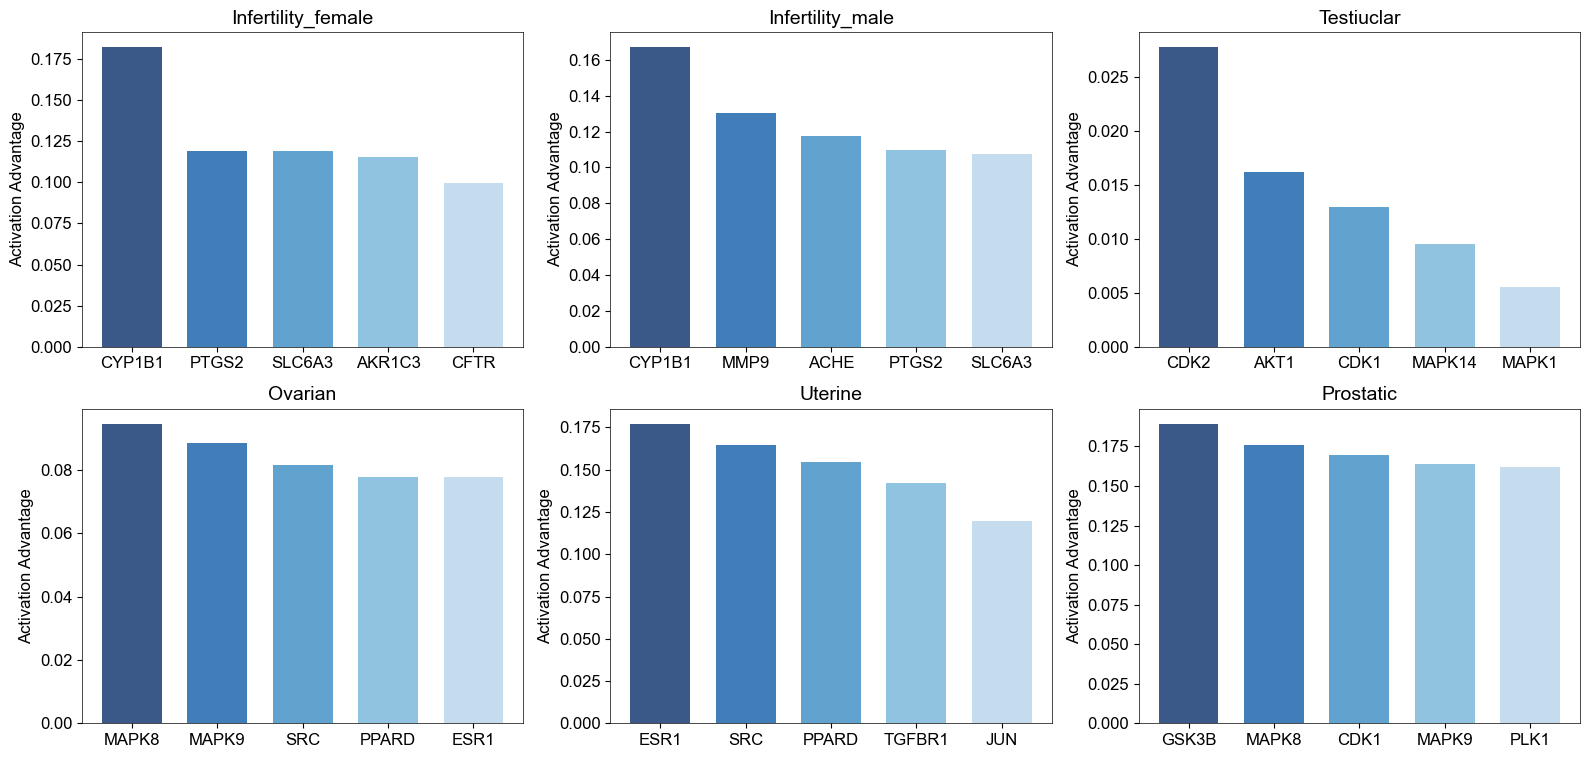

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm

# ===== Calculate the Top 5 disease-specific receptors for each disease =====
records = []
for i, disease in enumerate(diseases):
    disease_activations = receptor_disease_matrix[:, i]
    other_activations = np.mean(
        receptor_disease_matrix[:, [j for j in range(len(diseases)) if j != i]],
        axis=1
    )

    activation_advantage = disease_activations - other_activations
    top_specific_idx = np.argsort(activation_advantage)[-5:][::-1]

    for rank, idx in enumerate(top_specific_idx, 1):
        if activation_advantage[idx] > 0:  # Keep only receptors with positive advantage
            records.append({
                "Disease": disease,
                "Receptor": receptor_names[idx],
                "Advantage": activation_advantage[idx],
                "Rank": rank
            })

df_plot = pd.DataFrame(records)

# Set global font to Arial
plt.rcParams["font.family"] = "Arial"

# ===== Plot six small subplots in one figure =====
unique_diseases = df_plot["Disease"].unique()
n_diseases = len(unique_diseases)

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=False)
axes = axes.flatten()

# Use a blue gradient colormap
cmap = cm.get_cmap("Blues")

for i, disease in enumerate(unique_diseases):
    ax = axes[i]
    subset = df_plot[df_plot["Disease"] == disease].sort_values("Rank")

    # Create a gradient of blue shades by rank
    colors = [cmap(0.3 + 0.7 * (1 - (rank - 1) / 4)) for rank in subset["Rank"]]

    ax.bar(
        subset["Receptor"],
        subset["Advantage"],
        color=colors,
        alpha=0.8,
        width=0.7  # Make the bars narrower
    )

    # Make plot borders thinner
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    ax.set_title(disease, fontsize=14)
    ax.set_ylabel("Activation Advantage", fontsize=12)
    ax.set_xticklabels(subset["Receptor"], rotation=0, ha="center", fontsize=12)
    ax.tick_params(axis="y", labelsize=12)

# plt.savefig("disease_specific_receptors.svg", dpi=300)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:

# Analyze which receptors show the greatest differences across diseases
receptor_variance_across_diseases = np.var(receptor_disease_matrix, axis=1)
high_variance_idx = np.argsort(receptor_variance_across_diseases)[-10:][::-1]

print("Top 10 receptors with the largest variance across diseases:")
for i, idx in enumerate(high_variance_idx):
    variance = receptor_variance_across_diseases[idx]
    receptor_name = receptor_names[idx]
    
    # Display activation values of this receptor across all diseases
    activations = [f"{diseases[j]}:{receptor_disease_matrix[idx, j]:.2f}" 
                   for j in range(len(diseases))]
    print(f"  {i+1:2d}. {receptor_name:8s} (Variance: {variance:.4f}) - {' '.join(activations)}")


Top 10 receptors with the largest variance across diseases:
   1. SRC      (Variance: 0.0139) - Infertility_female:5.57 Infertility_male:5.64 Testiuclar:5.49 Ovarian:5.74 Uterine:5.81 Prostatic:5.79
   2. ESR1     (Variance: 0.0125) - Infertility_female:5.51 Infertility_male:5.55 Testiuclar:5.39 Ovarian:5.65 Uterine:5.73 Prostatic:5.66
   3. CYP1B1   (Variance: 0.0119) - Infertility_female:6.35 Infertility_male:6.33 Testiuclar:6.17 Ovarian:6.09 Uterine:6.06 Prostatic:6.16
   4. PPARD    (Variance: 0.0115) - Infertility_female:5.57 Infertility_male:5.62 Testiuclar:5.47 Ovarian:5.71 Uterine:5.78 Prostatic:5.74
   5. TGFBR1   (Variance: 0.0106) - Infertility_female:5.73 Infertility_male:5.80 Testiuclar:5.66 Ovarian:5.88 Uterine:5.94 Prostatic:5.92
   6. BRAF     (Variance: 0.0090) - Infertility_female:5.89 Infertility_male:5.96 Testiuclar:5.82 Ovarian:6.03 Uterine:6.07 Prostatic:6.08
   7. MAPK8    (Variance: 0.0084) - Infertility_female:5.36 Infertility_male:5.48 Testiuclar:5.47 Ovarian:

### 3 Disease clustering

In [12]:
data = receptor_data_scaled
disease_receptor_profiles = {}
receptor_summary_stats = []
all_top10 = []

for disease in diseases:
    df = data[disease]
    receptor_values = df[receptor_names].values
    
    # Calculate receptor activation metrics
    mean_activation = np.mean(receptor_values, axis=0)  # Mean activation for each receptor
    std_activation = np.std(receptor_values, axis=0)    # Activation variability for each receptor
    max_activation = np.max(receptor_values, axis=0)    # Maximum activation for each receptor
    
    # Compute total activation strength (sum of scores across 81 receptors)
    total_activation_per_chemical = np.sum(receptor_values, axis=1)  # Total activation per compound
    
    disease_receptor_profiles[disease] = {
        'receptor_means': mean_activation,
        'receptor_stds': std_activation,
        'receptor_maxs': max_activation,
        'total_activations': total_activation_per_chemical,
        'receptor_data': receptor_values
    }

# Analyze which receptors are most important for each specific disease
receptor_disease_matrix = np.zeros((len(receptor_names), len(diseases)))

for i, disease in enumerate(diseases):
    receptor_disease_matrix[:, i] = disease_receptor_profiles[disease]['receptor_means']


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

# Set global font to Arial
plt.rcParams["font.family"] = "Arial"

def plot_clustered_heatmap(data, row_labels, col_labels, title="", 
                           zscore=False, cmap='Blues', transpose=False):
    M = np.array(data, dtype=float)
    
    # Apply Z-score normalization if specified
    if zscore:
        mu = M.mean(axis=0, keepdims=True)
        sd = M.std(axis=0, keepdims=True)
        sd[sd == 0] = 1e-9
        M = (M - mu) / sd

    # Perform hierarchical clustering on rows
    Z_row = linkage(M, method='ward')
    row_order = leaves_list(Z_row)

    # Reorder rows based on clustering results
    M_reordered = M[row_order, :]
    row_labels_reordered = [row_labels[i] for i in row_order]
    col_labels_reordered = col_labels

    # Transpose if required
    if transpose:
        M_reordered = M_reordered.T
        row_labels_reordered, col_labels_reordered = col_labels_reordered, row_labels_reordered

    # Plot heatmap
    plt.figure(figsize=(20, 8))
    im = plt.pcolormesh(M_reordered, cmap=cmap, edgecolors='white', linewidth=0.5)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # Set axis labels and ticks
    plt.xticks(np.arange(len(col_labels_reordered)) + 0.5,
               col_labels_reordered, rotation=90, ha='right', fontsize=12, fontname="Arial")
    plt.yticks(np.arange(len(row_labels_reordered)) + 0.5,
               row_labels_reordered, fontsize=12, fontname="Arial")

    # plt.title(title + (" (clustered, transposed)" if transpose else " (clustered)"), 
    #           fontsize=14, weight="bold", fontname="Arial")
    plt.gca().invert_yaxis()
    plt.xlim(0, len(col_labels_reordered))
    plt.ylim(0, len(row_labels_reordered))
    plt.tight_layout()
    # plt.savefig("heatmap.svg", dpi=300, bbox_inches="tight")
    # plt.show()

    # Output x-axis label names
    df_gene = pd.DataFrame({"gene": col_labels_reordered})
    return df_gene
    # print("X-axis labels (in order):", col_labels_reordered)


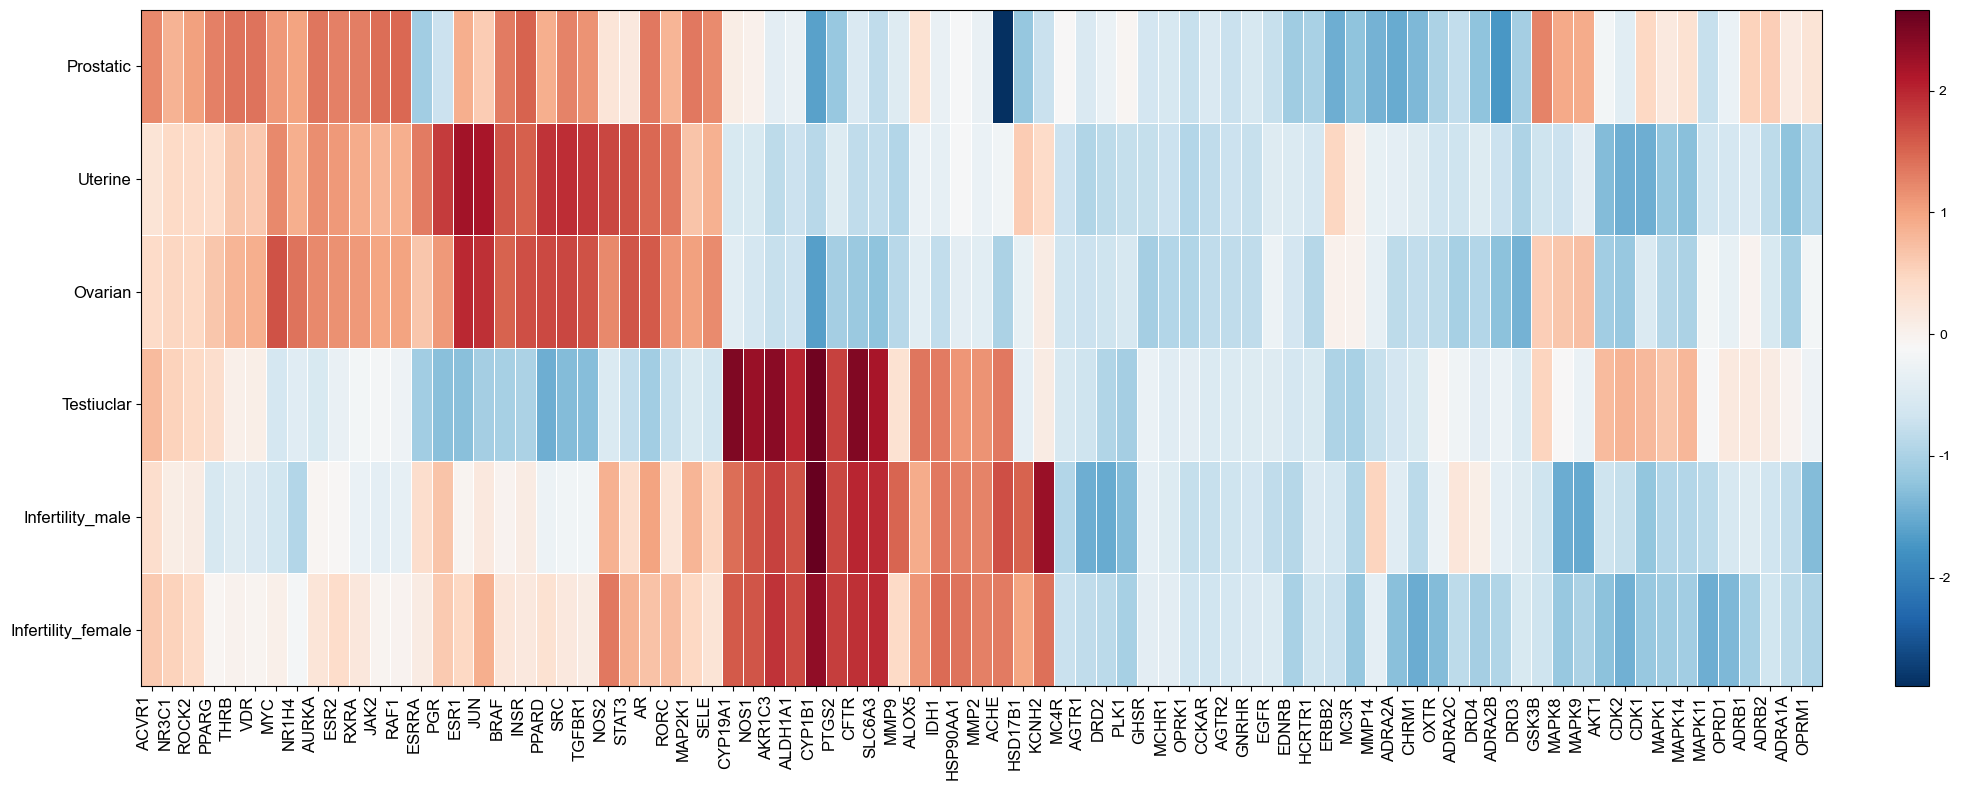

In [14]:
df_gene = plot_clustered_heatmap(
    receptor_disease_matrix,
    receptor_names,
    diseases,
    title="Receptor–Disease Heatmap",
    zscore=True,
    cmap='RdBu_r',
    transpose=True
)
# df_gene.to_csv('gene_order.csv',index=False)
